In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from tqdm import tqdm
import pandas as pd
plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [3]:
torch.manual_seed(0)


In [4]:
data_dir = "/scratch/mk7711/dast/datasets/style+traditional+og/aw/"
TRAIN = 'train'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, TEST]
}

batch_size=32
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=batch_size,
        shuffle=True, num_workers=5
    )
    for x in [TRAIN, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, TEST]}

for x in [TRAIN, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 25284 images under train
Loaded 498 images under test
Classes: 
['back_pack', 'bike', 'bike_helmet', 'bookcase', 'bottle', 'calculator', 'desk_chair', 'desk_lamp', 'desktop_computer', 'file_cabinet', 'headphones', 'keyboard', 'laptop_computer', 'letter_tray', 'mobile_phone', 'monitor', 'mouse', 'mug', 'paper_notebook', 'pen', 'phone', 'printer', 'projector', 'punchers', 'ring_binder', 'ruler', 'scissors', 'speaker', 'stapler', 'tape_dispenser', 'trash_can']


In [5]:
dataset_sizes

{'train': 25284, 'test': 498}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


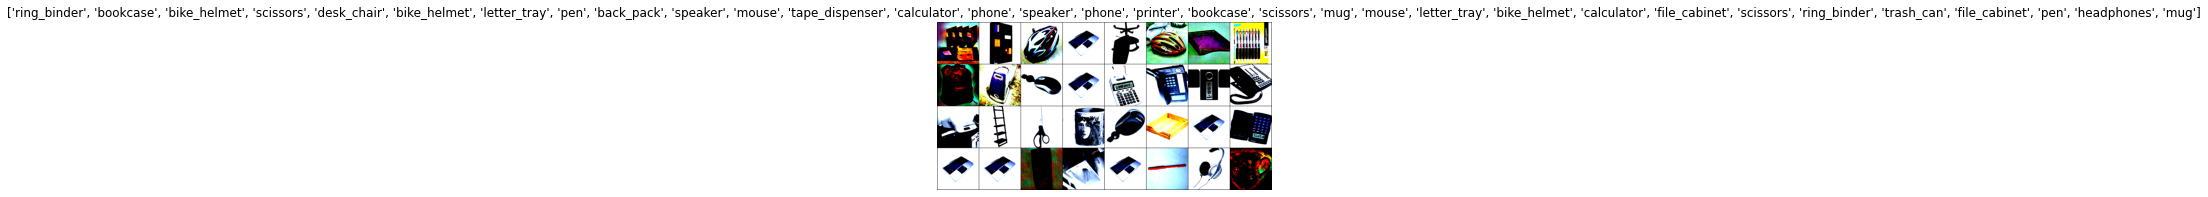

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    
    # Set model for evaluation
    model.train(False)
    model.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = model(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    model.train(mode=was_training) # Revert model back to original training state

In [8]:
def eval_model(model, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(tqdm(dataloaders[TEST])):
        #if i % 100 == 0:
         #   print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        model.train(False)
        model.eval()
        inputs, labels = data

        if use_gpu:
            with torch.no_grad():
                inputs, labels = inputs.to(device),labels.to(device)
                #inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
                
        loss_test += loss.data
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        #gc.collect()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    #print()
    #print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    #print("Avg loss (test): {:.4f}".format(avg_loss))
    #print("Avg acc (test): {:.4f}".format(avg_acc))
    #print('-' * 10)
    return avg_loss, avg_acc

In [ ]:
#For pre-trained model
model = models.vgg16(pretrained=True)

for param in model.features.parameters():
    param.require_grad = False

In [9]:
#For non pre-trained model
model = models.vgg16(pretrained=False)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
model.classifier = nn.Sequential(*features) # Replace the model classifier
print(model)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
    
criterion = nn.CrossEntropyLoss()
start_lr=0.0001
weight_decay=0.00001
step_size=30
gamma=0.1
epochs=100
optimizer_ft = optim.Adam(model.parameters(), lr=start_lr, weight_decay=weight_decay)
#optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.00001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=gamma)
if_lr=True
#exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, base_lr = 0.001, max_lr = 0.1, gamma=0.1,cycle_momentum=False)

cuda:0


In [11]:
history= []

In [12]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    
    train_batches = len(dataloaders[TRAIN])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        model.train(True)
        
        print("Training Progress: ", flush= True)
        for i, data in enumerate(tqdm(dataloaders[TRAIN])):
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = inputs.to(device), labels.to(device)
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        avg_loss = loss_train/ dataset_sizes[TRAIN]
        avg_acc = acc_train/ dataset_sizes[TRAIN]
        
        avg_loss_test, avg_acc_test= eval_model(model, criterion)
        
        history.append([avg_loss, avg_loss_test, avg_acc, avg_acc_test])
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Learning Rate: ", exp_lr_scheduler.get_lr())
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (test): {:.4f}".format(avg_loss_test))
        print("Avg acc (test): {:.4f}".format(avg_acc_test))
        print('-' * 10)
        print()
        
        exp_lr_scheduler.step()
        
        if avg_acc_test > best_acc:
            best_acc = avg_acc_test
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'vgg1-transfer.pt')
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model = train_model(model, criterion, optimizer_ft, num_epochs=epochs)
torch.save(model.state_dict(), 'vgg1-transfer.pt')

Epoch 0/100
----------
Training Progress: 


  0%|          | 0/16 [00:00<?, ?it/s]


Evaluating model
----------


100%|██████████| 16/16 [00:05<00:00,  3.08it/s]
/home/mk7711/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



Epoch 0 result: 
Learning Rate:  [0.0001]
Avg loss (train): 0.0917
Avg acc (train): 0.1870
Avg loss (test): 0.0655
Avg acc (test): 0.3916
----------

Epoch 1/100
----------
Training Progress: 


 19%|█▊        | 148/791 [01:47<06:39,  1.61it/s]

In [ ]:
history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc','valid_acc'])

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
         history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Testing Accuracy')

In [ ]:
test_loss, test_acc= eval_model(model, criterion)